In [1]:
import torch
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.__version__)

GeForce RTX 2080 Ti
True
1.2.0


In [2]:
torch.cuda.current_device()
torch.cuda.current_device()
torch.device('cuda')
torch.cuda.get_device_name(0)
torch.cuda.device_count()
torch.cuda.device(0)

 

In [3]:
# https://www.kaggle.com/corochann/bengali-seresnext-training-with-pytorch

In [4]:
import gc
import os
from pathlib import Path
import random
import sys
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [5]:
debug=False
submission=False
batch_size=120
device='cuda:0'
out='.'
image_size=128
arch='pretrained'
model_name='se_resnext50_32x4d'

In [6]:
datadir = Path('bengaliai-cv19/')
featherdir = Path('bengaliai-cv19/bengaliaicv19feather')
outdir = Path('.')

### Fast data loading

Refer Bengali.AI super fast data loading with feather and dataset for detail.
Original parquet format takes about 60 sec to load 1 data, while feather format takes about 2 sec to load 1 data!!!

In [7]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images

In [8]:
train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4


## Data Set

In [9]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError

In [10]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x

In [11]:
train_dataset = BengaliAIDataset(train_images, train_labels)

In [12]:
image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


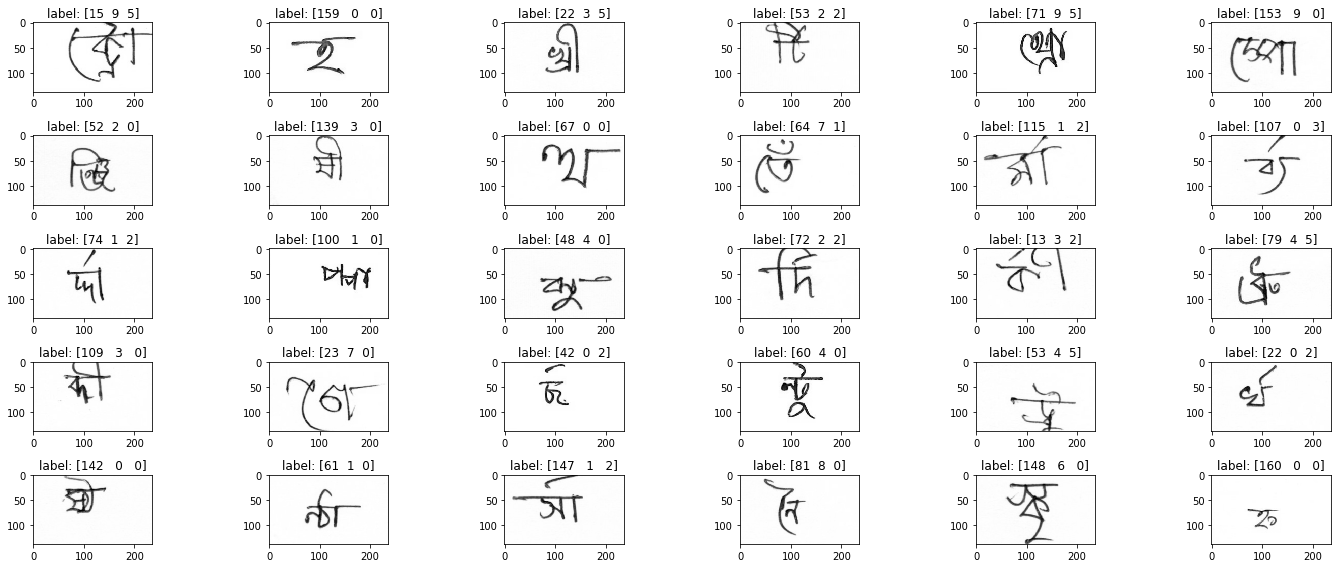

<Figure size 432x288 with 0 Axes>

In [13]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

## Data Augmentation

In [14]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image


def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

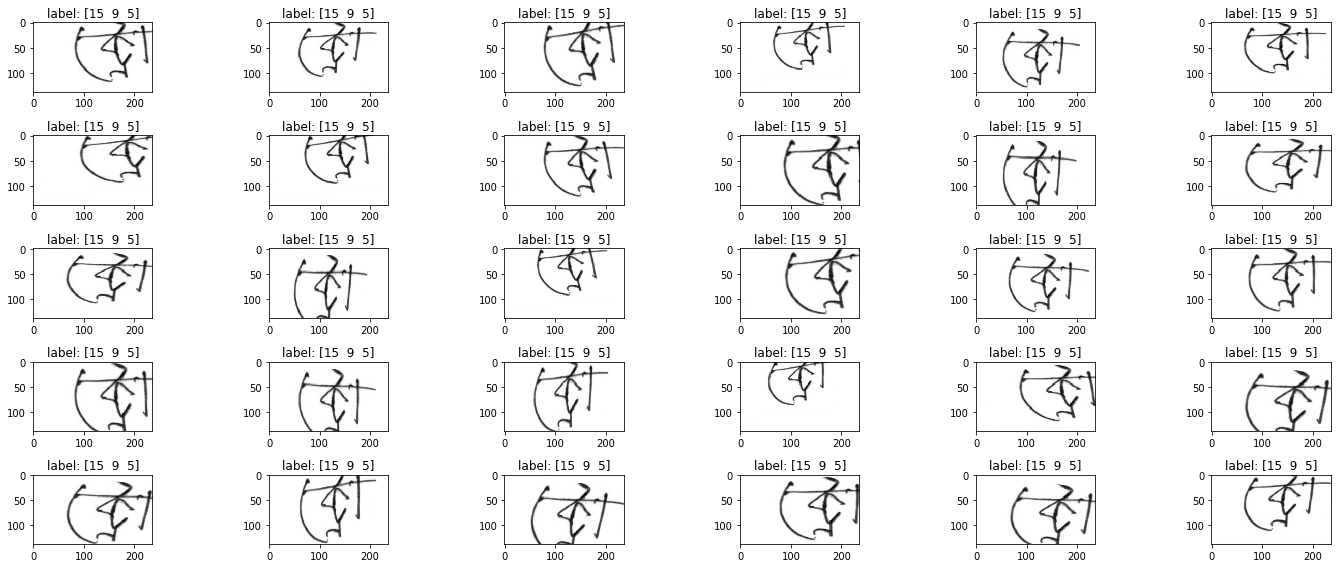

In [15]:

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

### Crop image

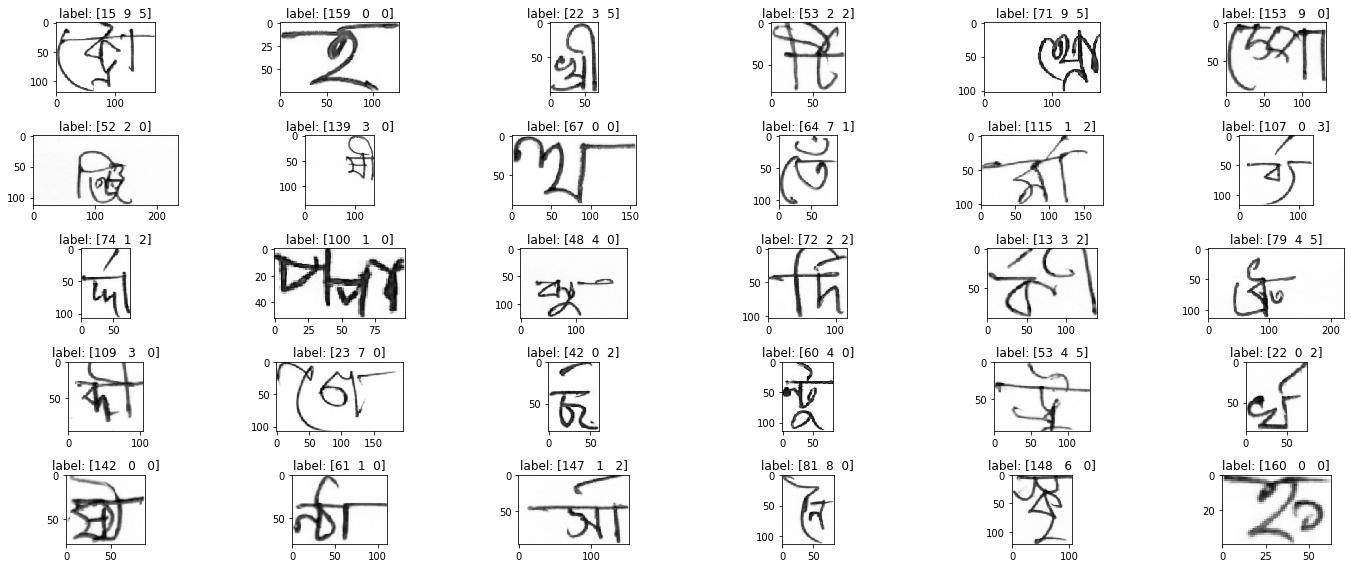

In [16]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(crop_char_image(image, threshold=20./255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

### Resize image

In [17]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[i]
#     ax.imshow(resize(crop_char_image(image, threshold=20./255.)), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Put everything together with Transform class.
[Update] I added albumentations augmentations introduced in Bengali: albumentations data augmentation tutorial.

In [18]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [19]:
train_transform = Transform(
    size=(image_size, image_size), threshold=20.,
    sigma=-1., blur_ratio=0.2, noise_ratio=0.2, cutout_ratio=0.2,
    grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
    piece_affine_ratio=0.2, ssr_ratio=0.2)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

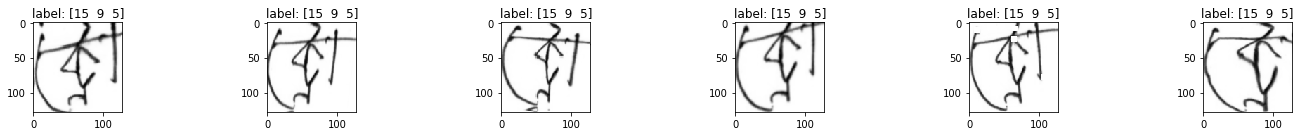

In [20]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## Pytorch model

In [21]:


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out

In [22]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))

In [23]:
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [24]:
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [25]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier


In [26]:
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

## Training

In [27]:
n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.9)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(777).permutation(n_dataset)
print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

perm [ 95762  34576  11800 ... 183206 113455  63591]
train_dataset 180756 valid_dataset 20084


In [28]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
print('predictor', type(predictor))

classifier = BengaliClassifier(predictor).to(device)

n_total 186
predictor <class '__main__.PretrainedCNN'>


## Ignite utility


In [29]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

In [30]:
import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)

    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()
        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        loss, metrics, pred_y = classifier(x, y)
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    trainer = Engine(update_fn)

    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)

    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            _, metrics, pred_y = classifier(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)

    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            # self.logger.warning(f'save model to {filepath}...')

In [31]:
import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float32)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)

In [32]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [33]:
batch_size
# train_dataset

120

In [34]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)#, num_workers=2)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))

C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\ignite\contrib\handlers\tqdm_logger.py:106: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [35]:
# https://discuss.pytorch.org/t/gpu-high-memory-usage-low-gpu-volatile-util/19856/5
trainer.run(train_loader, max_epochs=80)

C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



epoch      1 train/loss  2.559024 train/loss_grapheme  1.525954 train/loss_vowel  0.490247 train/loss_consonant  0.542823 train/acc_grapheme  0.671275 train/acc_vowel  0.887350 train/acc_consonant  0.887789 train/recall  0.741890 valid/loss  0.810778 valid/loss_grapheme  0.466957 valid/loss_vowel  0.159376 valid/loss_consonant  0.184444 valid/acc_grapheme  0.883167 valid/acc_vowel  0.964881 valid/acc_consonant  0.965986 valid/recall  0.914246 lr  0.001000 elapsed_time  1055.742529 


epoch      2 train/loss  0.809106 train/loss_grapheme  0.478026 train/loss_vowel  0.165533 train/loss_consonant  0.165547 train/acc_grapheme  0.882478 train/acc_vowel  0.960512 train/acc_consonant  0.962300 train/recall  0.914354 valid/loss  0.614851 valid/loss_grapheme  0.387438 valid/loss_vowel  0.110300 valid/loss_consonant  0.117113 valid/acc_grapheme  0.899734 valid/acc_vowel  0.972173 valid/acc_consonant  0.972682 valid/recall  0.931167 lr  0.001000 elapsed_time  2108.553634 


epoch      3 train/loss  0.599959 train/loss_grapheme  0.362902 train/loss_vowel  0.122686 train/loss_consonant  0.114371 train/acc_grapheme  0.907572 train/acc_vowel  0.968993 train/acc_consonant  0.970162 train/recall  0.933459 valid/loss  0.463589 valid/loss_grapheme  0.290403 valid/loss_vowel  0.090166 valid/loss_consonant  0.083019 valid/acc_grapheme  0.920847 valid/acc_vowel  0.976182 valid/acc_consonant  0.977918 valid/recall  0.946895 lr  0.001000 elapsed_time  3162.271810 


epoch      4 train/loss  0.497506 train/loss_grapheme  0.301070 train/loss_vowel  0.102135 train/loss_consonant  0.094301 train/acc_grapheme  0.922602 train/acc_vowel  0.973146 train/acc_consonant  0.974003 train/recall  0.943634 valid/loss  0.425640 valid/loss_grapheme  0.269899 valid/loss_vowel  0.076311 valid/loss_consonant  0.079430 valid/acc_grapheme  0.928562 valid/acc_vowel  0.979131 valid/acc_consonant  0.979068 valid/recall  0.947255 lr  0.001000 elapsed_time  4215.288628 


epoch      5 train/loss  0.428851 train/loss_grapheme  0.258528 train/loss_vowel  0.089815 train/loss_consonant  0.080508 train/acc_grapheme  0.932908 train/acc_vowel  0.975328 train/acc_consonant  0.977332 train/recall  0.950206 valid/loss  0.397448 valid/loss_grapheme  0.243870 valid/loss_vowel  0.081703 valid/loss_consonant  0.071875 valid/acc_grapheme  0.935457 valid/acc_vowel  0.977160 valid/acc_consonant  0.979464 valid/recall  0.951892 lr  0.001000 elapsed_time  5269.724742 


epoch      6 train/loss  0.375639 train/loss_grapheme  0.227378 train/loss_vowel  0.077452 train/loss_consonant  0.070808 train/acc_grapheme  0.939835 train/acc_vowel  0.979040 train/acc_consonant  0.979505 train/recall  0.955595 valid/loss  0.365096 valid/loss_grapheme  0.229548 valid/loss_vowel  0.070194 valid/loss_consonant  0.065354 valid/acc_grapheme  0.938086 valid/acc_vowel  0.981300 valid/acc_consonant  0.981498 valid/recall  0.952207 lr  0.001000 elapsed_time  6323.216298 


epoch      7 train/loss  0.331711 train/loss_grapheme  0.197622 train/loss_vowel  0.069219 train/loss_consonant  0.064871 train/acc_grapheme  0.946778 train/acc_vowel  0.980856 train/acc_consonant  0.980921 train/recall  0.959946 valid/loss  0.368940 valid/loss_grapheme  0.237179 valid/loss_vowel  0.069958 valid/loss_consonant  0.061803 valid/acc_grapheme  0.937329 valid/acc_vowel  0.981647 valid/acc_consonant  0.982837 valid/recall  0.955851 lr  0.001000 elapsed_time  7377.472768 


epoch      8 train/loss  0.301103 train/loss_grapheme  0.178361 train/loss_vowel  0.063732 train/loss_consonant  0.059009 train/acc_grapheme  0.951923 train/acc_vowel  0.982102 train/acc_consonant  0.982926 train/recall  0.963781 valid/loss  0.346043 valid/loss_grapheme  0.219987 valid/loss_vowel  0.064028 valid/loss_consonant  0.062028 valid/acc_grapheme  0.942961 valid/acc_vowel  0.983780 valid/acc_consonant  0.982071 valid/recall  0.957340 lr  0.001000 elapsed_time  8430.829216 


epoch      9 train/loss  0.271623 train/loss_grapheme  0.161745 train/loss_vowel  0.056924 train/loss_consonant  0.052954 train/acc_grapheme  0.955946 train/acc_vowel  0.983862 train/acc_consonant  0.984432 train/recall  0.967510 valid/loss  0.310458 valid/loss_grapheme  0.201112 valid/loss_vowel  0.057718 valid/loss_consonant  0.051627 valid/acc_grapheme  0.947240 valid/acc_vowel  0.985579 valid/acc_consonant  0.985394 valid/recall  0.964590 lr  0.001000 elapsed_time  9484.762090 


epoch     10 train/loss  0.243777 train/loss_grapheme  0.141653 train/loss_vowel  0.053664 train/loss_consonant  0.048460 train/acc_grapheme  0.960846 train/acc_vowel  0.984893 train/acc_consonant  0.985912 train/recall  0.970460 valid/loss  0.304680 valid/loss_grapheme  0.196032 valid/loss_vowel  0.057727 valid/loss_consonant  0.050922 valid/acc_grapheme  0.948341 valid/acc_vowel  0.984686 valid/acc_consonant  0.985232 valid/recall  0.962648 lr  0.001000 elapsed_time  10537.780029 


epoch     11 train/loss  0.232451 train/loss_grapheme  0.134975 train/loss_vowel  0.050713 train/loss_consonant  0.046762 train/acc_grapheme  0.962245 train/acc_vowel  0.985462 train/acc_consonant  0.985910 train/recall  0.971486 valid/loss  0.302790 valid/loss_grapheme  0.187932 valid/loss_vowel  0.057647 valid/loss_consonant  0.057211 valid/acc_grapheme  0.950609 valid/acc_vowel  0.985579 valid/acc_consonant  0.983631 valid/recall  0.962309 lr  0.001000 elapsed_time  11592.781323 


epoch     12 train/loss  0.211480 train/loss_grapheme  0.121724 train/loss_vowel  0.047068 train/loss_consonant  0.042688 train/acc_grapheme  0.965716 train/acc_vowel  0.986428 train/acc_consonant  0.987293 train/recall  0.973644 valid/loss  0.306595 valid/loss_grapheme  0.194642 valid/loss_vowel  0.059048 valid/loss_consonant  0.052904 valid/acc_grapheme  0.949729 valid/acc_vowel  0.985133 valid/acc_consonant  0.985728 valid/recall  0.965165 lr  0.001000 elapsed_time  12648.577958 


epoch     13 train/loss  0.193996 train/loss_grapheme  0.111108 train/loss_vowel  0.043580 train/loss_consonant  0.039309 train/acc_grapheme  0.968786 train/acc_vowel  0.987086 train/acc_consonant  0.988229 train/recall  0.976254 valid/loss  0.295156 valid/loss_grapheme  0.187247 valid/loss_vowel  0.054823 valid/loss_consonant  0.053086 valid/acc_grapheme  0.952593 valid/acc_vowel  0.986806 valid/acc_consonant  0.984673 valid/recall  0.967450 lr  0.001000 elapsed_time  13703.703504 


epoch     14 train/loss  0.182493 train/loss_grapheme  0.103268 train/loss_vowel  0.041417 train/loss_consonant  0.037808 train/acc_grapheme  0.970853 train/acc_vowel  0.987459 train/acc_consonant  0.988413 train/recall  0.976790 valid/loss  0.295179 valid/loss_grapheme  0.189204 valid/loss_vowel  0.053422 valid/loss_consonant  0.052553 valid/acc_grapheme  0.952854 valid/acc_vowel  0.987054 valid/acc_consonant  0.986422 valid/recall  0.963464 lr  0.001000 elapsed_time  14759.128895 


epoch     15 train/loss  0.167990 train/loss_grapheme  0.095345 train/loss_vowel  0.037937 train/loss_consonant  0.034708 train/acc_grapheme  0.972486 train/acc_vowel  0.988824 train/acc_consonant  0.989560 train/recall  0.978673 valid/loss  0.296078 valid/loss_grapheme  0.193473 valid/loss_vowel  0.051482 valid/loss_consonant  0.051124 valid/acc_grapheme  0.951502 valid/acc_vowel  0.987748 valid/acc_consonant  0.986174 valid/recall  0.964516 lr  0.001000 elapsed_time  15814.130845 


epoch     16 train/loss  0.157235 train/loss_grapheme  0.087507 train/loss_vowel  0.036896 train/loss_consonant  0.032833 train/acc_grapheme  0.974283 train/acc_vowel  0.988858 train/acc_consonant  0.989997 train/recall  0.979743 valid/loss  0.287911 valid/loss_grapheme  0.186137 valid/loss_vowel  0.052291 valid/loss_consonant  0.049483 valid/acc_grapheme  0.952593 valid/acc_vowel  0.986621 valid/acc_consonant  0.988046 valid/recall  0.965304 lr  0.001000 elapsed_time  16869.265804 


epoch     17 train/loss  0.148924 train/loss_grapheme  0.083587 train/loss_vowel  0.034728 train/loss_consonant  0.030610 train/acc_grapheme  0.975664 train/acc_vowel  0.989462 train/acc_consonant  0.990679 train/recall  0.980645 valid/loss  0.285805 valid/loss_grapheme  0.182930 valid/loss_vowel  0.051999 valid/loss_consonant  0.050876 valid/acc_grapheme  0.954428 valid/acc_vowel  0.987103 valid/acc_consonant  0.987018 valid/recall  0.967171 lr  0.001000 elapsed_time  17923.927709 


epoch     18 train/loss  0.139581 train/loss_grapheme  0.077890 train/loss_vowel  0.031864 train/loss_consonant  0.029827 train/acc_grapheme  0.977273 train/acc_vowel  0.990384 train/acc_consonant  0.990732 train/recall  0.981596 valid/loss  0.292634 valid/loss_grapheme  0.189793 valid/loss_vowel  0.053461 valid/loss_consonant  0.049380 valid/acc_grapheme  0.953089 valid/acc_vowel  0.987960 valid/acc_consonant  0.986323 valid/recall  0.965434 lr  0.001000 elapsed_time  18978.468619 


epoch     19 train/loss  0.129146 train/loss_grapheme  0.071717 train/loss_vowel  0.030077 train/loss_consonant  0.027353 train/acc_grapheme  0.978631 train/acc_vowel  0.990708 train/acc_consonant  0.991368 train/recall  0.982642 valid/loss  0.298765 valid/loss_grapheme  0.192448 valid/loss_vowel  0.053538 valid/loss_consonant  0.052779 valid/acc_grapheme  0.954861 valid/acc_vowel  0.986918 valid/acc_consonant  0.986558 valid/recall  0.966378 lr  0.001000 elapsed_time  20032.206764 


epoch     20 train/loss  0.126242 train/loss_grapheme  0.069023 train/loss_vowel  0.029360 train/loss_consonant  0.027859 train/acc_grapheme  0.979770 train/acc_vowel  0.990881 train/acc_consonant  0.991243 train/recall  0.983637 valid/loss  0.313387 valid/loss_grapheme  0.199935 valid/loss_vowel  0.057766 valid/loss_consonant  0.055686 valid/acc_grapheme  0.953585 valid/acc_vowel  0.985814 valid/acc_consonant  0.985665 valid/recall  0.965334 lr  0.001000 elapsed_time  21086.158244 


epoch     21 train/loss  0.118785 train/loss_grapheme  0.065002 train/loss_vowel  0.028540 train/loss_consonant  0.025244 train/acc_grapheme  0.980893 train/acc_vowel  0.991130 train/acc_consonant  0.992163 train/recall  0.984826 valid/loss  0.308743 valid/loss_grapheme  0.201872 valid/loss_vowel  0.053342 valid/loss_consonant  0.053528 valid/acc_grapheme  0.951998 valid/acc_vowel  0.987414 valid/acc_consonant  0.985764 valid/recall  0.965489 lr  0.001000 elapsed_time  22142.444643 


epoch     22 train/loss  0.114995 train/loss_grapheme  0.061665 train/loss_vowel  0.027974 train/loss_consonant  0.025356 train/acc_grapheme  0.981835 train/acc_vowel  0.991446 train/acc_consonant  0.992251 train/recall  0.985137 valid/loss  0.300480 valid/loss_grapheme  0.193047 valid/loss_vowel  0.055507 valid/loss_consonant  0.051925 valid/acc_grapheme  0.953238 valid/acc_vowel  0.986670 valid/acc_consonant  0.986954 valid/recall  0.966123 lr  0.001000 elapsed_time  23197.572590 


epoch     23 train/loss  0.107303 train/loss_grapheme  0.058092 train/loss_vowel  0.025416 train/loss_consonant  0.023795 train/acc_grapheme  0.983121 train/acc_vowel  0.991963 train/acc_consonant  0.992662 train/recall  0.986173 valid/loss  0.318765 valid/loss_grapheme  0.204950 valid/loss_vowel  0.056686 valid/loss_consonant  0.057130 valid/acc_grapheme  0.952282 valid/acc_vowel  0.986706 valid/acc_consonant  0.985119 valid/recall  0.963524 lr  0.001000 elapsed_time  24253.139147 


epoch     24 train/loss  0.106445 train/loss_grapheme  0.056257 train/loss_vowel  0.026074 train/loss_consonant  0.024115 train/acc_grapheme  0.983179 train/acc_vowel  0.991916 train/acc_consonant  0.992590 train/recall  0.986005 valid/loss  0.302817 valid/loss_grapheme  0.191467 valid/loss_vowel  0.059352 valid/loss_consonant  0.051998 valid/acc_grapheme  0.957616 valid/acc_vowel  0.986657 valid/acc_consonant  0.987130 valid/recall  0.967438 lr  0.001000 elapsed_time  25309.437105 


epoch     25 train/loss  0.098873 train/loss_grapheme  0.051755 train/loss_vowel  0.024856 train/loss_consonant  0.022261 train/acc_grapheme  0.984642 train/acc_vowel  0.992292 train/acc_consonant  0.993182 train/recall  0.987603 valid/loss  0.320532 valid/loss_grapheme  0.202612 valid/loss_vowel  0.058081 valid/loss_consonant  0.059839 valid/acc_grapheme  0.954365 valid/acc_vowel  0.986508 valid/acc_consonant  0.985714 valid/recall  0.963667 lr  0.001000 elapsed_time  26365.671700 


epoch     26 train/loss  0.097237 train/loss_grapheme  0.052099 train/loss_vowel  0.024033 train/loss_consonant  0.021105 train/acc_grapheme  0.984627 train/acc_vowel  0.992297 train/acc_consonant  0.993204 train/recall  0.987321 valid/loss  0.308668 valid/loss_grapheme  0.201965 valid/loss_vowel  0.053542 valid/loss_consonant  0.053160 valid/acc_grapheme  0.953698 valid/acc_vowel  0.987811 valid/acc_consonant  0.987004 valid/recall  0.967272 lr  0.001000 elapsed_time  27420.055450 


epoch     27 train/loss  0.092818 train/loss_grapheme  0.048614 train/loss_vowel  0.023612 train/loss_consonant  0.020592 train/acc_grapheme  0.985768 train/acc_vowel  0.992352 train/acc_consonant  0.993503 train/recall  0.987894 valid/loss  0.322117 valid/loss_grapheme  0.207877 valid/loss_vowel  0.059980 valid/loss_consonant  0.054260 valid/acc_grapheme  0.953549 valid/acc_vowel  0.986756 valid/acc_consonant  0.986756 valid/recall  0.965050 lr  0.001000 elapsed_time  28473.739427 


epoch     28 train/loss  0.089359 train/loss_grapheme  0.046560 train/loss_vowel  0.022669 train/loss_consonant  0.020130 train/acc_grapheme  0.986069 train/acc_vowel  0.992806 train/acc_consonant  0.993648 train/recall  0.988057 valid/loss  0.306937 valid/loss_grapheme  0.200697 valid/loss_vowel  0.055850 valid/loss_consonant  0.050390 valid/acc_grapheme  0.954915 valid/acc_vowel  0.987216 valid/acc_consonant  0.987861 valid/recall  0.967531 lr  0.001000 elapsed_time  29529.422793 


epoch     29 train/loss  0.088348 train/loss_grapheme  0.045445 train/loss_vowel  0.022572 train/loss_consonant  0.020331 train/acc_grapheme  0.986478 train/acc_vowel  0.992725 train/acc_consonant  0.993973 train/recall  0.988736 valid/loss  0.338909 valid/loss_grapheme  0.218664 valid/loss_vowel  0.059822 valid/loss_consonant  0.060424 valid/acc_grapheme  0.953102 valid/acc_vowel  0.985926 valid/acc_consonant  0.986012 valid/recall  0.966832 lr  0.001000 elapsed_time  30584.575797 


epoch     30 train/loss  0.086004 train/loss_grapheme  0.044484 train/loss_vowel  0.022097 train/loss_consonant  0.019423 train/acc_grapheme  0.986771 train/acc_vowel  0.993016 train/acc_consonant  0.993923 train/recall  0.988665 valid/loss  0.325156 valid/loss_grapheme  0.213430 valid/loss_vowel  0.055967 valid/loss_consonant  0.055758 valid/acc_grapheme  0.954676 valid/acc_vowel  0.987811 valid/acc_consonant  0.986806 valid/recall  0.965714 lr  0.001000 elapsed_time  31640.333307 


epoch     31 train/loss  0.082243 train/loss_grapheme  0.042516 train/loss_vowel  0.020604 train/loss_consonant  0.019123 train/acc_grapheme  0.987385 train/acc_vowel  0.993469 train/acc_consonant  0.994081 train/recall  0.989316 valid/loss  0.329342 valid/loss_grapheme  0.213146 valid/loss_vowel  0.061821 valid/loss_consonant  0.054375 valid/acc_grapheme  0.952904 valid/acc_vowel  0.986756 valid/acc_consonant  0.986075 valid/recall  0.962116 lr  0.001000 elapsed_time  32694.228250 


epoch     32 train/loss  0.080572 train/loss_grapheme  0.040728 train/loss_vowel  0.021341 train/loss_consonant  0.018503 train/acc_grapheme  0.988058 train/acc_vowel  0.993342 train/acc_consonant  0.994249 train/recall  0.989749 valid/loss  0.321224 valid/loss_grapheme  0.211648 valid/loss_vowel  0.055853 valid/loss_consonant  0.053722 valid/acc_grapheme  0.952841 valid/acc_vowel  0.987414 valid/acc_consonant  0.987004 valid/recall  0.966493 lr  0.001000 elapsed_time  33748.596146 


epoch     33 train/loss  0.077031 train/loss_grapheme  0.040147 train/loss_vowel  0.019863 train/loss_consonant  0.017021 train/acc_grapheme  0.988316 train/acc_vowel  0.993805 train/acc_consonant  0.994669 train/recall  0.990302 valid/loss  0.331715 valid/loss_grapheme  0.214762 valid/loss_vowel  0.060281 valid/loss_consonant  0.056673 valid/acc_grapheme  0.953819 valid/acc_vowel  0.986075 valid/acc_consonant  0.986756 valid/recall  0.965922 lr  0.001000 elapsed_time  34802.830059 


epoch     34 train/loss  0.074709 train/loss_grapheme  0.037662 train/loss_vowel  0.019817 train/loss_consonant  0.017229 train/acc_grapheme  0.988660 train/acc_vowel  0.993818 train/acc_consonant  0.994537 train/recall  0.990598 valid/loss  0.328289 valid/loss_grapheme  0.211599 valid/loss_vowel  0.064514 valid/loss_consonant  0.052176 valid/acc_grapheme  0.955357 valid/acc_vowel  0.986806 valid/acc_consonant  0.987798 valid/recall  0.967207 lr  0.001000 elapsed_time  35857.372739 


Current run is terminating due to exception: .
Engine run is terminating due to exception: .


KeyboardInterrupt: 

In [36]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

,epoch,iteration,train/loss,train/loss_grapheme,train/loss_vowel,train/loss_consonant,train/acc_grapheme,train/acc_vowel,train/acc_consonant,train/recall,valid/loss,valid/loss_grapheme,valid/loss_vowel,valid/loss_consonant,valid/acc_grapheme,valid/acc_vowel,valid/acc_consonant,valid/recall,lr,elapsed_time
0,1,1507,2.559024,1.525954,0.490247,0.542823,0.671275,0.887350,0.887789,0.741890,0.810778,0.466957,0.159376,0.184444,0.883167,0.964881,0.965986,0.914246,0.001,1055.742529
1,2,3014,0.809106,0.478026,0.165533,0.165547,0.882478,0.960512,0.962300,0.914354,0.614851,0.387438,0.110300,0.117113,0.899734,0.972173,0.972682,0.931167,0.001,2108.553634
2,3,4521,0.599959,0.362902,0.122686,0.114371,0.907572,0.968993,0.970162,0.933459,0.463589,0.290403,0.090166,0.083019,0.920847,0.976182,0.977918,0.946895,0.001,3162.271810
3,4,6028,0.497506,0.301070,0.102135,0.094301,0.922602,0.973146,0.974003,0.943634,0.425640,0.269899,0.076311,0.079430,0.928562,0.979131,0.979068,0.947255,0.001,4215.288628
4,5,7535,0.428851,0.258528,0.089815,0.080508,0.932908,0.975328,0.977332,0.950206,0.397448,0.243870,0.081703,0.071875,0.935457,0.977160,0.979464,0.951892,0.001,5269.724742
5,6,9042,0.375639,0.227378,0.077452,0.070808,0.939835,0.979040,0.979505,0.955595,0.365096,0.229548,0.070194,0.065354,0.938086,0.981300,0.981498,0.952207,0.001,6323.216298
6,7,10549,0.331711,0.197622,0.069219,0.064871,0.946778,0.980856,0.980921,0.959946,0.368940,0.237179,0.069958,0.061803,0.937329,0.981647,0.982837,0.955851,0.001,7377.472768
7,8,12056,0.301103,0.178361,0.063732,0.059009,0.951923,0.982102,0.982926,0.963781,0.346043,0.219987,0.064028,0.062028,0.942961,0.983780,0.982071,0.957340,0.001,8430.829216
8,9,13563,0.271623,0.161745,0.056924,0.052954,0.955946,0.983862,0.984432,0.967510,0.310458,0.201112,0.057718,0.051627,0.947240,0.985579,0.985394,0.964590,0.001,9484.762090
9,10,15070,0.243777,0.141653,0.053664,0.048460,0.960846,0.984893,0.985912,0.970460,0.304680,0.196032,0.057727,0.050922,0.948341,0.984686,0.985232,0.962648,0.001,10537.780029
